In [ ]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:

def interpret_vit(image, text, model, device, index=None):
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    if index is None:
        index = np.argmax(logits_per_image.cpu().data.numpy(), axis=-1)
    one_hot = np.zeros((1, logits_per_image.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    for blk in image_attn_blocks:
        grad = blk.attn_grad
        cam = blk.attn_probs
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.clamp(min=0).mean(dim=0)
        R += torch.matmul(cam, R)
    R[0, 0] = 0
    image_relevance = R[0, 1:]

    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    plt.imshow(vis)
#     plt.show()

In [ ]:
import streamlit as st

from torchray.attribution.grad_cam import grad_cam
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

st.sidebar.header('Options')
alpha = st.sidebar.radio("select alpha", [0.5, 0.7, 0.8], index=1)
layer = st.sidebar.selectbox("select saliency layer", ['layer4.2.relu'], index=0)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_rn, preprocess = clip.load("RN50", device=device, jit=False)

def interpret_rn(image, text, model, device, index=None):   
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features_new = image_features / image_features_norm
    text_features_norm = text_features.norm(dim=-1, keepdim=True)
    text_features_new = text_features / text_features_norm
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features_new @ text_features_new.t()
    probs = logits_per_image.softmax(dim=-1).cpu().detach().numpy().tolist()
    
    text_prediction = (text_features_new * image_features_norm)
    image_relevance = grad_cam(model.visual, image.type(model.dtype), text_prediction, saliency_layer=layer)
        
#     image_relevance = grad_cam(model.visual, image.type(model.dtype), image_features, saliency_layer=layer)

    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    plt.imshow(vis)

2021-05-13 23:59:19.960 WARNING root: 
  command:

    streamlit run /rscratch/sheng/anaconda3/envs/mmdet/lib/python3.7/site-packages/ipykernel_launcher.py [ARGUMENTS]
/rscratch/sheng/anaconda3/envs/mmdet/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

/rscratch/sheng/anaconda3/envs/mmdet/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

/rscratch/sheng/anaconda3/envs/mmdet/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Compose(
    Resize(size=224, interpolation=bicubic)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x7fd8a8b09c20>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
text: What color is the woman's shirt on the left?


/rscratch/sheng/anaconda3/envs/mmdet/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


text: What color is the woman's shirt on the left?


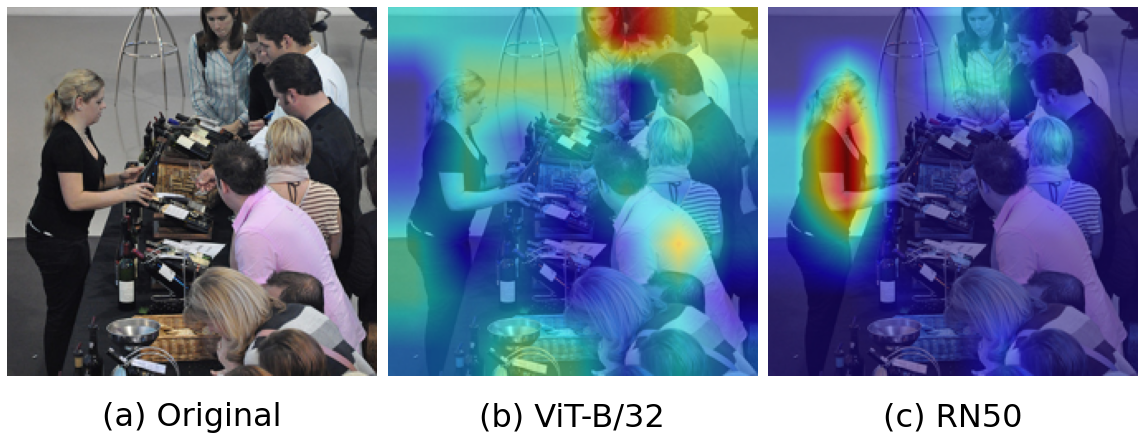

In [ ]:
img_id = 'COCO_val2014_000000393267'
MSCOCO_IMG_ROOT = "/rscratch/data/coco_2014/images"

# COCO_val2014_000000393267 What color is the woman's shirt on the left? {'black': 1, 'blonde': 0.3}
import os
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
    CenterCrop(size=(224, 224)),
        ToTensor()])
img_path = os.path.join(MSCOCO_IMG_ROOT, "val2014", img_id + ".jpg")

image = ori_preprocess(Image.open(img_path))
print(preprocess)

from matplotlib import rc

font = {
    'size': 32,
}
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# matplotlib.rcParams['mathtext.size'] = 16

# {'cursive', 'fantasy', 'monospace', 'sans', 'sans serif', 'sans-serif', 'serif'}
plt.figure(figsize=(16, 16))
plt.tight_layout()
plt.subplot(131)
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.title("(a) Original", **font, y=-0.15)

# plt.savefig('/rscratch/sheng.s/clip_boi/clip_vqa_starting/visual/sample_1_ori.pdf', bbox_inches='tight')
# plt.show()

image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["What color is the woman's shirt on the left?"]
text = clip.tokenize(texts).to(device)
print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[0] + color.END)
plt.subplot(132)
interpret_vit(model=model, image=image, text=text, device=device, index=0)
plt.axis('off')
plt.title("(b) ViT-B/32", **font,y=-0.15)

image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
# texts = ["What color is the woman's shirt on the left?"]
text = clip.tokenize(texts).to(device)
plt.subplot(133)
print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[0] + color.END)
interpret_rn(model=model_rn, image=image, text=text, device=device, index=0)
plt.axis('off')
plt.title("(c) RN50", **font,y=-0.15)
plt.tight_layout()

plt.savefig('/rscratch/sheng.s/clip_boi/clip_vqa_starting/visual/sample_all.pdf', bbox_inches='tight')